In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import warnings
from scipy.signal import find_peaks
from scipy.optimize import curve_fit
from scipy.ndimage import gaussian_filter1d

sys.path.insert(0, "../")

import warnings
warnings.filterwarnings('ignore')

from michael import janet

2022-10-19 12:08:20.947479: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
uni = pd.read_csv("/Users/oliver hall/Research/unicorn/data/unicorn.csv", index_col=0)

In [8]:
index = uni[uni.source_id == int(38329666836450304)].index[0]

In [11]:
uni.loc[index, ['source_id','ra','dec']]

source_id    38329666836450304
ra                   59.560442
dec                  12.627969
Name: 224, dtype: object

Already have data downloaded for Gaia ID 38329666836450304.
### Running Simple Astropy Lomb-Scargle on Sector 5 on star 38329666836450304 ###
### Completed Simple Astropy Lomb-Scargle for Sector 5 on star 38329666836450304 ###
### Running Wavelet Estimation for Sector 5 on star 38329666836450304 ###


100%|█████████████████████████████████████████| 760/760 [00:14<00:00, 50.86it/s]


### Completed Wavelet Estimation for Sector 5 on star 38329666836450304 ###
### Running Composite ACF estimation for Sector 5 on star 38329666836450304 ###
### Completed Composite ACF estimation for Sector 5 on star 38329666836450304 ###
### Running ACF Estimation on star 38329666836450304 ###
### Completed ACF Estimation for Sector 5 on star 38329666836450304 ###
### Running Simple Astropy Lomb-Scargle on Sector 32 on star 38329666836450304 ###
### Completed Simple Astropy Lomb-Scargle for Sector 32 on star 38329666836450304 ###
### Running Wavelet Estimation for Sector 32 on star 38329666836450304 ###


100%|█████████████████████████████████████████| 764/764 [00:27<00:00, 28.00it/s]


### Completed Wavelet Estimation for Sector 32 on star 38329666836450304 ###
### Running Composite ACF estimation for Sector 32 on star 38329666836450304 ###
### Completed Composite ACF estimation for Sector 32 on star 38329666836450304 ###
### Running ACF Estimation on star 38329666836450304 ###
### Completed ACF Estimation for Sector 32 on star 38329666836450304 ###
### Running Simple Astropy Lomb-Scargle on Sector 42-44 on star 38329666836450304 ###
### Completed Simple Astropy Lomb-Scargle for Sector 42-44 on star 38329666836450304 ###
### Running Wavelet Estimation for Sector 42-44 on star 38329666836450304 ###


100%|███████████████████████████████████████| 2288/2288 [03:04<00:00, 12.41it/s]


### Completed Wavelet Estimation for Sector 42-44 on star 38329666836450304 ###
### Running Composite ACF estimation for Sector 42-44 on star 38329666836450304 ###
### Completed Composite ACF estimation for Sector 42-44 on star 38329666836450304 ###
### Running ACF Estimation on star 38329666836450304 ###
### Completed ACF Estimation for Sector 42-44 on star 38329666836450304 ###


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


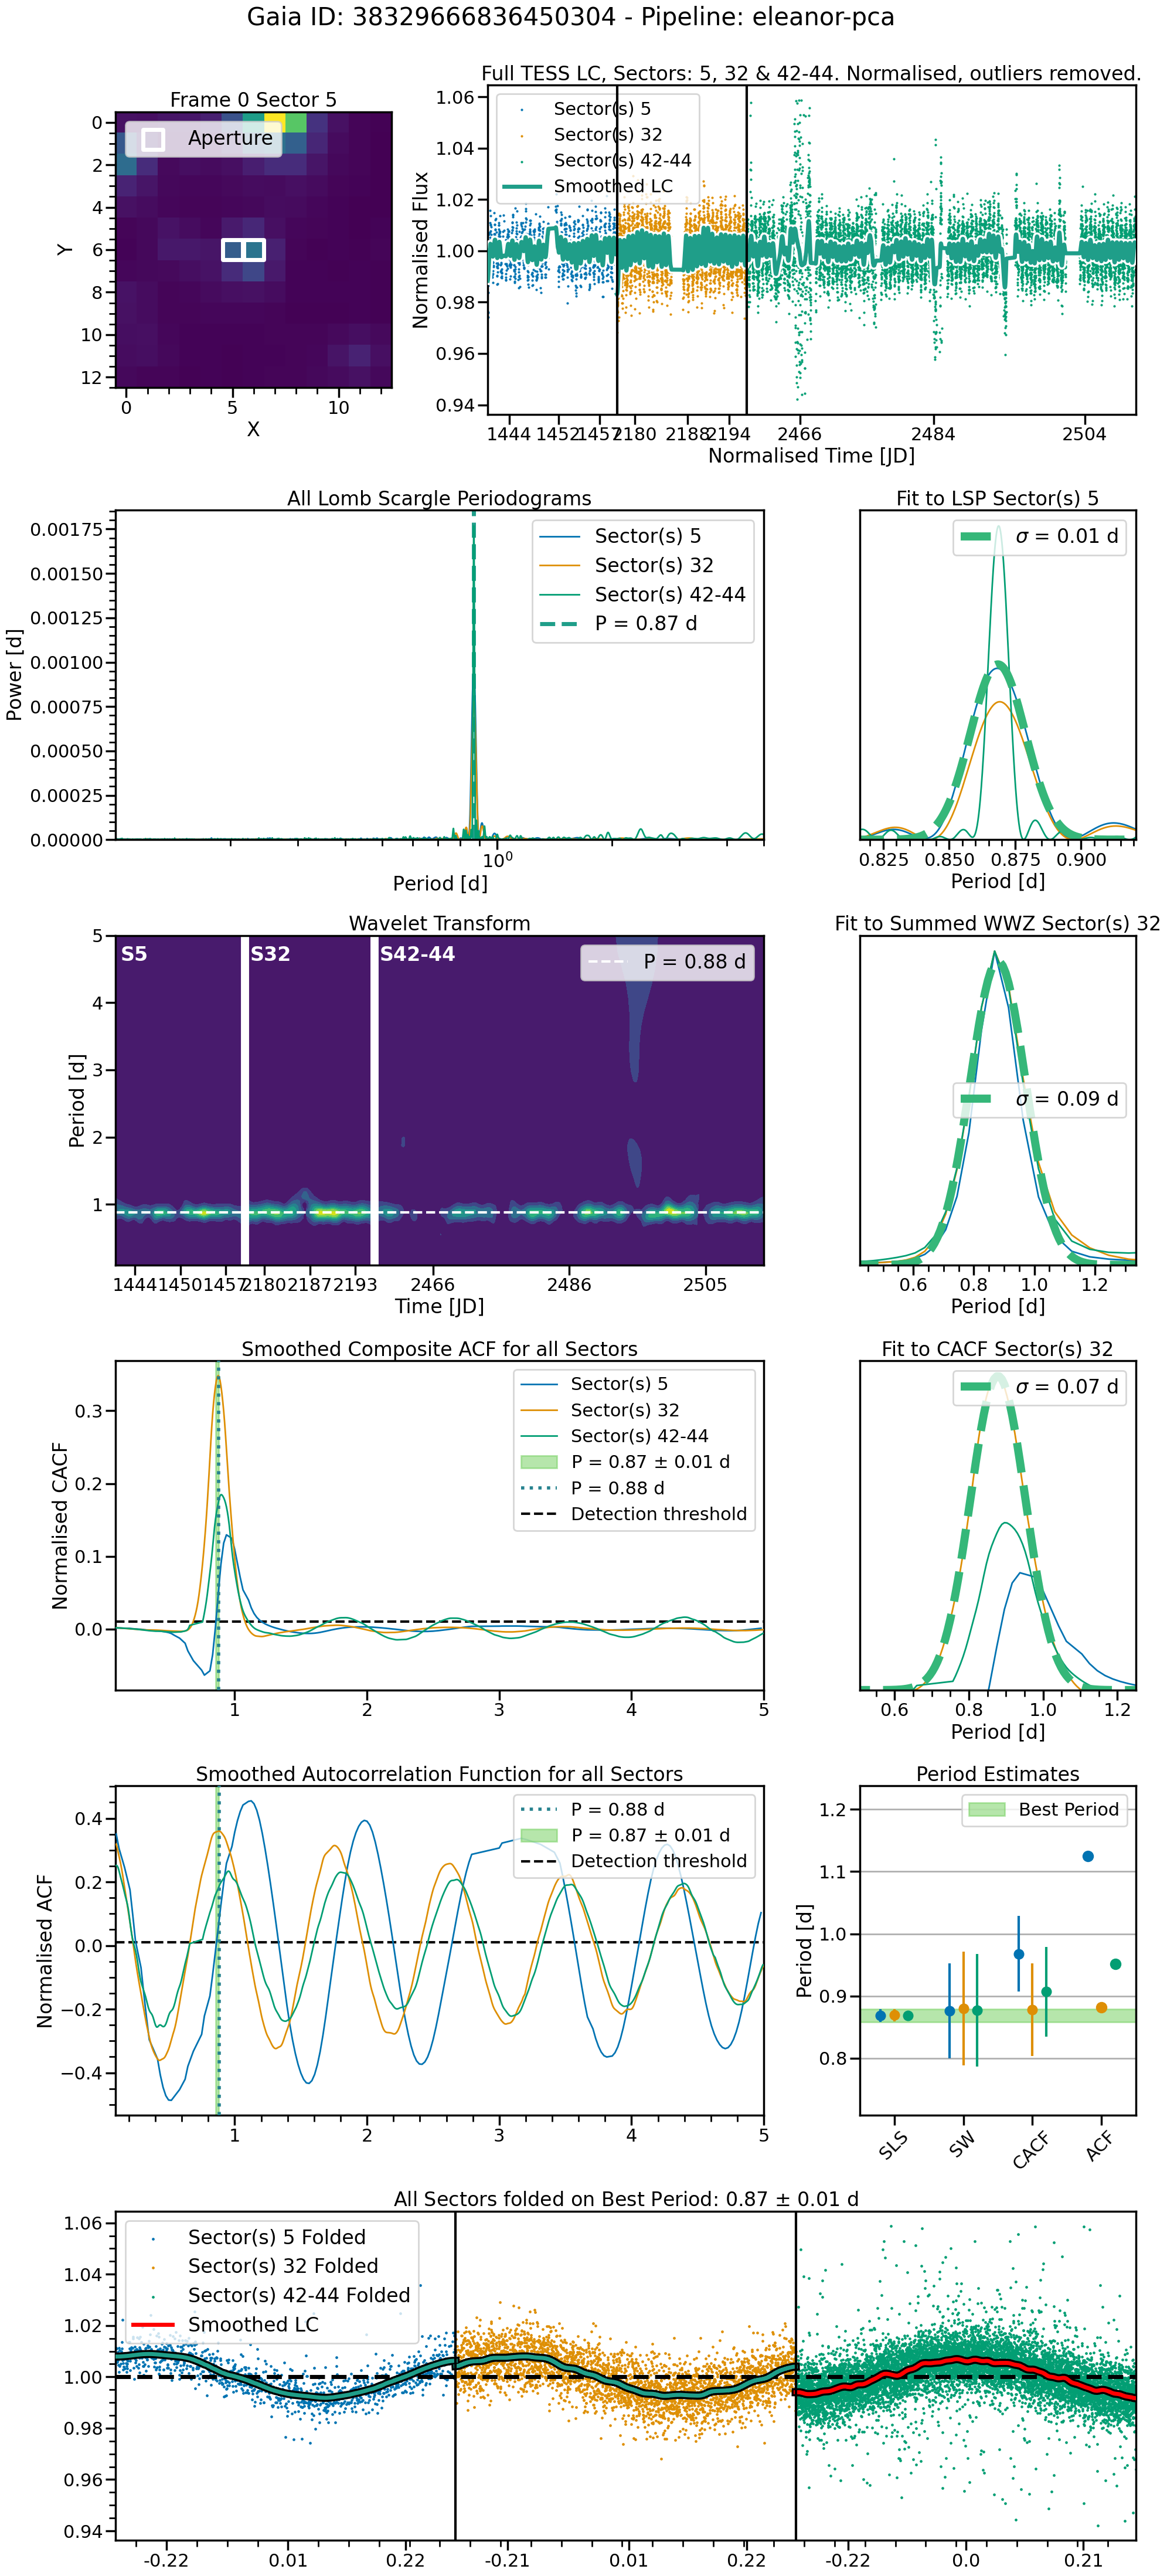

In [9]:
for method in ['eleanor-pca']:#'eleanor', 'eleanor-corner','eleanor-pca', 'unpopular','tess-sip']:
    j = janet.boot(uni, index=index, pipeline = method)
    j.prepare_data()
    j.get_rotation(period_range=(0.1, 5))
    j.validate_rotation()
    j.view()
    plt.show()

In [12]:
j.results

,SLS,e_SLS,h_SLS,f_SLS,SW,e_SW,h_SW,CACF,e_CACF,h_CACF,...,f_p2p_ACF,s_SLS,s_SW,s_CACF,s_ACF,f_overall,overall,e_overall,method_overall,p2p_overall
5,0.868501,0.010462,0.000987,0.0,0.876201,0.076339,0.952228,0.967965,0.060735,0.140364,...,0.0,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN
32,0.869394,0.010036,0.000793,0.0,0.879662,0.091223,0.967928,0.878267,0.074325,0.346597,...,0.0,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN
42-44,0.868732,0.003489,0.001800,0.0,0.877398,0.090186,0.966707,0.906939,0.072144,0.186089,...,0.0,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN
best,0.868501,0.010462,0.000987,0.0,0.879662,0.091223,0.967928,0.878267,0.074325,0.346597,...,NaN,5,32,32,32,0,0.868501,0.010462,SLS,0.017082


In [15]:
all(np.diff(j.sectorlist) == 1)

False

In [ ]:
sys.exit()

Plot lightcurves

In [ ]:
ax = j.void['clc_33-34'].plot(label='eleanor')

pls = ['c','raw','pca','corn','r', 'cpm']
for pl in pls:
    j.void[f'{pl}lc_33-34'].plot(ax=ax, label=pl)
ax.legend(fontsize=10)

In [ ]:
ax = j.void['clc_16-17'].to_periodogram(maximum_period=27).plot(label='eleanor', view='period')

pls = ['c','raw','pca','corn','r', 'cpm']
for pl in pls:
    j.void[f'{pl}lc_16-17'].to_periodogram(maximum_period=27).plot(ax=ax, label=pl,view='period', scale='log')
    ax.axvline(j.void[f'{pl}lc_16-17'].to_periodogram(maximum_period=27).period_at_max_power.value)
    print(j.void[f'{pl}lc_16-17'].to_periodogram(maximum_period=27).period_at_max_power)
ax.legend(fontsize=10)